In [51]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

#### GPU is a powerful tool in training model

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load a dataset

In [53]:
train_dataset = torchvision.datasets.MNIST(root='../datasets/mnist/train', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../datasets/mnist/test', train=False, transform=transforms.ToTensor(), download=True)

In [54]:
#train_dataset.data

In [55]:
#train_dataset.data.max()

In [56]:
#train_dataset.data.shape

In [57]:
#train_dataset.targets

In [58]:
#test_dataset.data.shape

### Build a model

In [59]:
model = nn.Sequential(
    nn.Linear(784, 128), # input size 28 x 28 = 784
    nn.ReLU(),
    nn.Linear(128, 10) # no need for the softmax here
)

In [60]:
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

### Loss and optimizer

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [62]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Train the model

In [63]:
n_epochs = 10

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = [] # per batch
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # reshape the input
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
      
        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

  
    # Get train loss and test loss
    train_loss = np.mean(train_loss) 
  

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 784)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch 1/10, Train Loss: 0.421139, Test Loss: 0.238218
Epoch 2/10, Train Loss: 0.199446, Test Loss: 0.168783
Epoch 3/10, Train Loss: 0.144714, Test Loss: 0.129567
Epoch 4/10, Train Loss: 0.113989, Test Loss: 0.109009
Epoch 5/10, Train Loss: 0.091670, Test Loss: 0.100526
Epoch 6/10, Train Loss: 0.075720, Test Loss: 0.085875
Epoch 7/10, Train Loss: 0.064244, Test Loss: 0.081259
Epoch 8/10, Train Loss: 0.054522, Test Loss: 0.074038
Epoch 9/10, Train Loss: 0.046273, Test Loss: 0.081184
Epoch 10/10, Train Loss: 0.039912, Test Loss: 0.071138


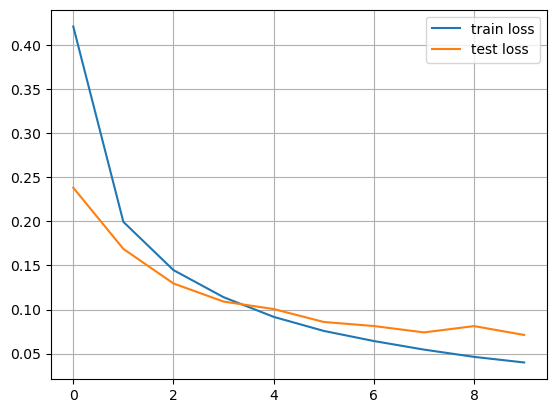

In [64]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.grid()
plt.legend()
plt.show()

#### Calculate the accuracy

In [66]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 784)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
  
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # reshape the input
    inputs = inputs.view(-1, 784)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
  
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.6f}, Test acc: {test_acc:.6f}")

Train acc: 0.992050, Test acc: 0.978200


#### Plot confusion matrix

In [67]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
      print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Do these results make sense?
# It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc. 

Confusion matrix, without normalization
[[ 965    0    1    2    0    1    5    1    3    2]
 [   0 1124    3    1    0    1    2    1    3    0]
 [   4    1 1010    3    1    0    2    5    6    0]
 [   0    0    2  992    0    2    0    5    4    5]
 [   0    0    4    0  956    0    5    4    2   11]
 [   2    1    0   10    1  862    5    2    7    2]
 [   4    3    2    1    1    3  943    0    1    0]
 [   0    9    7    3    0    0    0  997    3    9]
 [   3    1    2    5    4    3    2    1  949    4]
 [   0    4    0    5    8    2    1    1    4  984]]


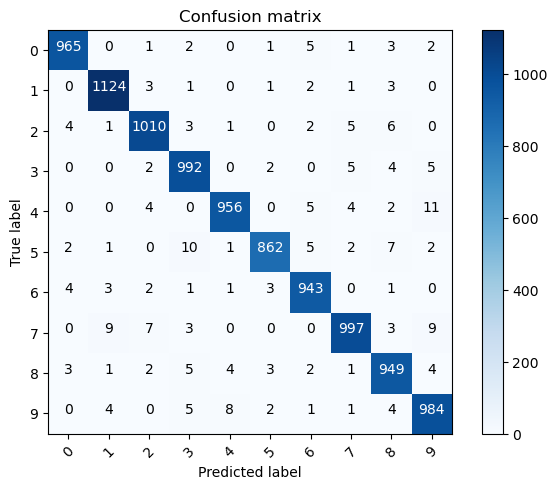

In [68]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)

    # reshape the input
    inputs = inputs.view(-1, 784)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    _, predictions = torch.max(outputs, 1)
  
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

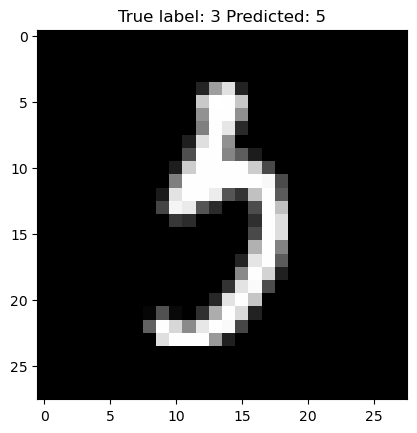

In [69]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], int(p_test[i])));